# Домашнее задание для Junior DS по разработке PD модели

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

### Импортируем библиотеки

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scorecardpy as sc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [7]:
plt.rcParams.update({'figure.max_open_warning': 0})

In [8]:
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 30)

### Подгружаем данные

In [4]:
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
!wget https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-desc.csv

--2022-08-22 19:42:00--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5329268 (5.1M) [text/plain]
Saving to: ‘PD-data-train.csv’

PD-data-train.csv   100%[===================>]   5.08M  --.-KB/s    in 0.05s   

2022-08-22 19:42:00 (113 MB/s) - ‘PD-data-train.csv’ saved [5329268/5329268]

--2022-08-22 19:42:00--  https://raw.githubusercontent.com/BKHV/risk_models/master/data/PD-data-test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28259 (28K

In [5]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')
desc_df = pd.read_csv('PD-data-desc.csv', sep=';')

### Exploratory data analysis

Описание данных

In [6]:
desc_df.head()

,field,desc_eng,desc_rus
0,ar_revenue,Sales revenue (at the end of the last year),Выручка от реализации (на конец последнего года)
1,ar_total_expenses,Total expenses for the last year,Общие расходы за последний год
2,ar_sale_cost,Cost of sales (at the end of the last year),Себестоимость продаж (на конец последнего года)
3,ar_selling_expenses,Selling expenses (at the end of the last year),Коммерческие расходы (на конец последнего года)
4,ar_management_expenses,Administrative expenses (at the end of the las...,Управленческие расходы (на конец последнего года)


Семплы и размеры выборок

In [9]:
train_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,...,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,0.0,1198000.0,0.0,7240000.0,4988000.0,...,11349000.0,4523000.0,0.0,198,136,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,256,135,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,33,33,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,0.0,1919000.0,0.0,4245000.0,4082000.0,...,3652000.0,0.0,0.0,185,139,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,0.0,711000.0,0.0,8950000.0,8606000.0,...,0.0,1279000.0,0.0,220,138,27,27,27,[1-100],10000.0,2,0,0,0,0


In [10]:
train_df.shape

(32395, 37)

In [11]:
test_df.head()

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,...,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg
0,196,39103000.0,38913000.0,38913000.0,0.0,0.0,190000.0,141000.0,331000.0,284000.0,0.0,47000.0,0.0,6009000.0,2451000.0,...,0.0,3000000.0,3130000.0,0.0,156,135,3,3,3,[1-100],100000.0,1,0,0,0
1,1196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,216,138,5,5,5,[1-100],100000.0,1,0,0,0
2,2813,54174000.0,50929000.0,50929000.0,0.0,0.0,3245000.0,-1278000.0,1967000.0,500000.0,0.0,1467000.0,0.0,8175000.0,8037000.0,...,0.0,0.0,3906000.0,0.0,244,138,20,20,20,[1-100],250000.0,2,0,0,0
3,4385,1904000.0,1679000.0,1679000.0,0.0,0.0,225000.0,-88000.0,137000.0,0.0,0.0,137000.0,0.0,5790000.0,4314000.0,...,0.0,500000.0,40000.0,0.0,272,139,9,9,9,[1-100],10000.0,2,0,0,0
4,6479,225584000.0,210685000.0,210685000.0,0.0,0.0,14899000.0,-12715000.0,2184000.0,445000.0,0.0,1739000.0,0.0,65485000.0,46006000.0,...,0.0,16215000.0,30802000.0,0.0,254,139,3,3,3,(100-500],1700598.0,84,0,0,0


In [12]:
test_df.shape

(200, 36)

Количество разных типов фичей

In [13]:
train_df.dtypes.value_counts()

float64    25
int64      11
object      1
dtype: int64

Целевой признак

In [18]:
train_df.default_12m.value_counts()

0    30304
1     2091
Name: default_12m, dtype: int64

Уровень дефолт-рейта в выборке = 6,7219%

In [14]:
train_df['default_12m'].values.mean()

0.06454699799351751

In [15]:
train_df.record_id.nunique()

32395

32395 уникальных наблюдений

In [16]:
A1 = set(train_df.record_id.values)
A2 = set(test_df.record_id.values)
print(len(A1-A2), len(A1&A2), len(A2-A1))

32395 0 200


In [19]:
lst = []
for name in train_df.columns:
    nu = len(train_df[name].unique())
    nisnan = train_df[name].isnull().sum()
    lst.append([name, nu, nisnan, train_df[name].unique()[:min(nu, 10)]])

pd.DataFrame(lst, columns=['column', 'nunique', 'nnull', 'values'])

,column,nunique,nnull,values
0,record_id,32395,0,"[7, 13, 18, 22, 23, 24, 30, 37, 38, 40]"
1,ar_revenue,12894,15145,"[52996000.0, nan, 32049000.0, 16458000.0, 1254..."
2,ar_total_expenses,12780,15145,"[48344000.0, nan, 29568000.0, 14935000.0, 1226..."
3,ar_sale_cost,12665,15145,"[48344000.0, nan, 29568000.0, 14935000.0, 1226..."
4,ar_selling_expenses,1995,15145,"[0.0, nan, 16442000.0, 29191000.0, 50000.0, 21..."
5,ar_management_expenses,1094,15145,"[0.0, nan, 1242000.0, 78000.0, 37161000.0, 386..."
6,ar_sale_profit,7164,15145,"[4652000.0, nan, 2481000.0, 1523000.0, 2777000..."
7,ar_balance_of_rvns_and_expns,5064,15145,"[-2608000.0, nan, -260000.0, -274000.0, -63000..."
8,ar_profit_before_tax,6527,15145,"[2044000.0, nan, 2221000.0, 1249000.0, 2714000..."
9,ar_taxes,2248,15145,"[846000.0, nan, 302000.0, 538000.0, 579000.0, ..."


Признак ul_systematizing_flg имеет только одно значение

In [20]:
train_df.ul_systematizing_flg.value_counts()

0    32395
Name: ul_systematizing_flg, dtype: int64

In [21]:
test_df.ul_systematizing_flg.value_counts()

0    200
Name: ul_systematizing_flg, dtype: int64

In [22]:
columns_a = [name for name in train_df.columns if (name[:2]=='ar') | (name[:2]=='ab')]
print(columns_a)

['ar_revenue', 'ar_total_expenses', 'ar_sale_cost', 'ar_selling_expenses', 'ar_management_expenses', 'ar_sale_profit', 'ar_balance_of_rvns_and_expns', 'ar_profit_before_tax', 'ar_taxes', 'ar_other_profit_and_losses', 'ar_net_profit', 'ab_immobilized_assets', 'ab_mobile_current_assets', 'ab_inventory', 'ab_accounts_receivable', 'ab_other_current_assets', 'ab_cash_and_securities', 'ab_losses', 'ab_own_capital', 'ab_borrowed_capital', 'ab_long_term_liabilities', 'ab_short_term_borrowing', 'ab_accounts_payable', 'ab_other_borrowings']


In [23]:
lst = []
for name in columns_a:
    lst.append([name,
                train_df[name].isnull().mean(),
                test_df[name].isnull().mean(),
                (train_df[name] < 0).sum(),
                (test_df[name] < 0).sum(),
                (train_df[name] == 0).sum(),
                (test_df[name] == 0).sum()
               ])

pd.DataFrame(lst, columns=['column', 'train_null', 'test_null', 'train<0', 'test<0', 'train=0', 'test=0'])

,column,train_null,test_null,train<0,test<0,train=0,test=0
0,ar_revenue,0.46751,0.59,0,0,393,7
1,ar_total_expenses,0.46751,0.59,18,0,364,6
2,ar_sale_cost,0.46751,0.59,18,0,457,6
3,ar_selling_expenses,0.46751,0.59,5,0,14644,70
4,ar_management_expenses,0.46751,0.59,6,0,15860,79
5,ar_sale_profit,0.46751,0.59,1685,8,403,6
6,ar_balance_of_rvns_and_expns,0.46751,0.59,12073,56,1993,12
7,ar_profit_before_tax,0.46751,0.59,1494,9,385,4
8,ar_taxes,0.46751,0.59,343,2,5487,30
9,ar_other_profit_and_losses,0.46751,0.59,33,0,15736,75


In [24]:
cols = list(train_df.columns)
subset = cols.copy()
subset.remove('record_id')
train_df[train_df.duplicated(subset=subset)]

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,...,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
137,1043,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,13,13,13,13,13,[1-100],10000.0,1,0,0,0,0
456,3924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,37,37,3,3,3,[1-100],10000.0,1,0,0,0,0
489,4141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,16,16,16,16,16,[1-100],10000.0,2,0,0,0,0
496,4181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15,15,16,16,16,[1-100],10000.0,1,0,0,0,0
516,4348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9,9,9,9,9,[1-100],10000.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32377,274484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,15,15,5,5,5,[1-100],10000.0,1,0,0,0,0
32378,274489,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,66,66,23,23,23,[1-100],10000.0,1,0,0,0,0
32380,274497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,43,43,24,24,24,[1-100],10000.0,1,0,0,0,0
32384,274530,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2,2,2,2,2,[1-100],10000.0,1,0,0,0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(train_df[columns_a], train_df['default_12m'], test_size=0.33)

X_train = X_train.fillna(0.0).values

X_test = X_test.fillna(0.0).values

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

a1 = model.predict_proba(X_train)[:, 1]
a2 = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_train, a1), roc_auc_score(y_test, a2)

(0.6194332905509123, 0.6071833528794965)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_df[columns_a], train_df['default_12m'], test_size=0.33)

X_train = X_train.fillna(0.0).values
X_train = np.sign(X_train) * np.log1p(np.abs(X_train))

X_test = X_test.fillna(0.0).values
X_test = np.sign(X_test) * np.log1p(np.abs(X_test))

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

a1 = model.predict_proba(X_train)[:, 1]
a2 = model.predict_proba(X_test)[:, 1]

roc_auc_score(y_train, a1), roc_auc_score(y_test, a2)

# с преобразованиями (0.6336110915112516, 0.6102997270501094)
# без преобразований (0.6194332905509123, 0.6071833528794965)

(0.6336110915112516, 0.6102997270501094)

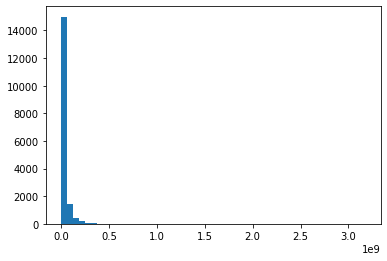

In [28]:
f = train_df['ab_mobile_current_assets'].values
plt.hist(f, bins=50)
plt.show()

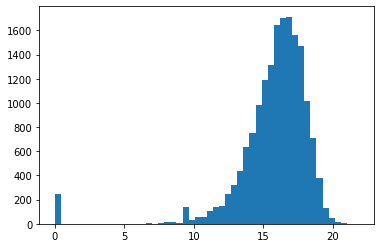

In [29]:
f = train_df['ab_mobile_current_assets'].values
plt.hist(np.log1p(f), bins=50)
plt.show()

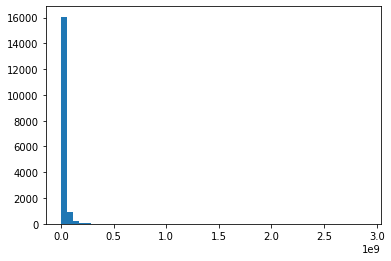

In [30]:
f = train_df['ab_inventory'].values
plt.hist(f, bins=50)
plt.show()

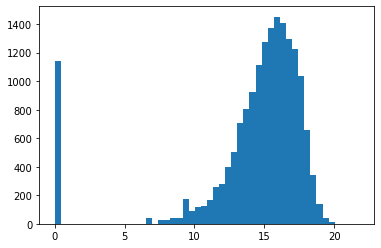

In [31]:
f = train_df['ab_inventory'].values
plt.hist(np.log1p(f), bins=50)
plt.show()

### Feature Engineering

In [32]:
train_test_df = pd.concat([train_df, test_df], sort=False)

In [33]:
train_test_df['current_ratio'] = train_test_df.ab_mobile_current_assets / train_test_df.ab_short_term_borrowing
train_test_df['quick_ratio'] = (train_test_df.ab_accounts_receivable + train_test_df.ab_cash_and_securities) / train_test_df.ab_short_term_borrowing
train_test_df['cash_ratio'] = train_test_df.ab_cash_and_securities / train_test_df.ab_short_term_borrowing
train_test_df['return_on_sales'] = train_test_df.ar_sale_profit / train_test_df.ar_revenue
train_test_df['net_profit_margin'] = train_test_df.ar_net_profit / train_test_df.ar_revenue
train_test_df['return_on_assets'] = train_test_df.ar_net_profit / (train_test_df.ab_immobilized_assets + train_test_df.ab_mobile_current_assets)
train_test_df['return_on_production'] = train_test_df.ar_profit_before_tax / (train_test_df.ab_immobilized_assets + train_test_df.ab_mobile_current_assets)
train_test_df['return_on_equity'] = train_test_df.ar_net_profit / train_test_df.ab_own_capital
train_test_df['permanent_asset_index'] = train_test_df.ab_immobilized_assets / train_test_df.ab_own_capital
train_test_df['working_capital_mobility_ratio'] = train_test_df.ab_cash_and_securities / train_test_df.ab_mobile_current_assets
train_test_df['reserves_coverage_ratio'] = train_test_df.ab_mobile_current_assets / train_test_df.ab_inventory
train_test_df['short-term_debt_ratio'] = train_test_df.ab_short_term_borrowing / (train_test_df.ab_long_term_liabilities + train_test_df.ab_other_borrowings + train_test_df.ab_short_term_borrowing)
train_test_df['F01'] = train_test_df.ar_revenue / train_test_df.ab_immobilized_assets
train_test_df['F02'] = train_test_df.ar_sale_cost / train_test_df.ab_inventory
train_test_df['F03'] = train_test_df.ar_revenue / train_test_df.ab_accounts_receivable
train_test_df['F04'] = train_test_df.ar_selling_expenses / train_test_df.ar_total_expenses
train_test_df['F05'] = train_test_df.ar_revenue / (train_test_df.ab_own_capital + train_test_df.ab_borrowed_capital) - (train_test_df.ab_long_term_liabilities + train_test_df.ab_other_borrowings + train_test_df.ab_short_term_borrowing)
train_test_df['F06'] = train_test_df.ar_revenue / (train_test_df.ab_mobile_current_assets + train_test_df.ab_cash_and_securities)
train_test_df['F07'] = train_test_df.ar_profit_before_tax / train_test_df.ar_revenue
train_test_df['F08'] = train_test_df.ab_short_term_borrowing / (train_test_df.ab_short_term_borrowing + train_test_df.ab_accounts_payable + train_test_df.ab_other_borrowings)
train_test_df['F09'] = train_test_df.ab_accounts_payable / (train_test_df.ab_short_term_borrowing + train_test_df.ab_accounts_payable + train_test_df.ab_other_borrowings)
train_test_df['F10'] = train_test_df.ab_inventory / train_test_df.ar_revenue
train_test_df['F11'] = train_test_df.ab_long_term_liabilities / train_test_df.ar_revenue
train_test_df['F12'] = train_test_df.ar_taxes / train_test_df.ar_revenue
train_test_df['F13'] = train_test_df.ab_inventory / train_test_df.ab_borrowed_capital
train_test_df['F14'] = train_test_df.ab_inventory / train_test_df.ab_accounts_payable
train_test_df['F15'] = train_test_df.ab_accounts_receivable / (train_test_df.ab_cash_and_securities + train_test_df.ab_accounts_receivable)
train_test_df['F16'] = train_test_df.ab_cash_and_securities / train_test_df.ab_borrowed_capital
train_test_df['F17'] = train_test_df.ab_cash_and_securities / (train_test_df.ab_short_term_borrowing + train_test_df.ab_accounts_payable)
train_test_df['F18'] = train_test_df.ab_cash_and_securities / (train_test_df.ab_short_term_borrowing + train_test_df.ab_accounts_payable + train_test_df.ab_other_borrowings)
train_test_df['F19'] = train_test_df.ab_mobile_current_assets / (train_test_df.ab_long_term_liabilities + train_test_df.ab_other_borrowings + train_test_df.ab_short_term_borrowing)
train_test_df['F20'] = (train_test_df.ab_accounts_receivable + train_test_df.ab_cash_and_securities) / (train_test_df.ab_long_term_liabilities + train_test_df.ab_other_borrowings + train_test_df.ab_short_term_borrowing)
train_test_df['F21'] = train_test_df.ab_cash_and_securities / (train_test_df.ab_long_term_liabilities + train_test_df.ab_other_borrowings + train_test_df.ab_short_term_borrowing)
train_test_df['F22'] = train_test_df.ar_profit_before_tax / train_test_df.ar_net_profit
train_test_df['F23'] = (train_test_df.ab_long_term_liabilities + train_test_df.ab_other_borrowings + train_test_df.ab_short_term_borrowing) / (train_test_df.ab_own_capital + train_test_df.ab_borrowed_capital)
train_test_df['F24'] = (train_test_df.ab_accounts_receivable + train_test_df.ab_cash_and_securities) / (train_test_df.ab_own_capital + train_test_df.ab_borrowed_capital)

In [34]:
train_test_df['ul_staff_range'].unique()

array(['[1-100]', '(100-500]', '> 500'], dtype=object)

In [35]:
train_test_df.loc[train_test_df['ul_staff_range'] == '[1-100]', 'ul_staff_range'] = 1
train_test_df.loc[train_test_df['ul_staff_range'] == '(100-500]', 'ul_staff_range'] = 2
train_test_df.loc[train_test_df['ul_staff_range'] == '> 500', 'ul_staff_range'] = 3

In [36]:
data_std = train_test_df.std(axis=0, ddof=0, skipna=True) 
for col in train_test_df.columns:
    if data_std[col] < 0.2:
        print(col, data_std[col])

ul_strategic_flg 0.00959323642580424
ul_systematizing_flg 0.0
F04 0.08507060072214176


In [37]:
train_test_df.ul_strategic_flg.value_counts()

0    32592
1        3
Name: ul_strategic_flg, dtype: int64

In [38]:
train_test_df = train_test_df.drop(['ul_systematizing_flg', 'ul_strategic_flg'], axis=1)

In [39]:
for col in columns_a:
    train_test_df[col] = np.sign(train_test_df[col]) * np.log1p(np.abs(train_test_df[col]))

In [41]:
test_data = train_test_df.iloc[-len(test_df):, :].copy()
train_data = train_test_df.iloc[:-len(test_df), :].copy()

In [42]:
cols = list(train_data.columns)
subset = cols.copy()
subset.remove('record_id')
train_data.drop_duplicates(subset=subset, inplace=True)
train_data.drop(['record_id'], axis=1, inplace=True)

In [43]:
train_df_1 = train_data[train_data['ar_revenue'].isnull()].copy()
train_df_2 = train_data[~train_data['ar_revenue'].isnull()].copy()

In [44]:
train_df_1.shape

(10215, 70)

In [45]:
train_df_2.shape

(16375, 70)

In [46]:
nan_column_1 = train_df_1.columns[train_df_1.isnull().any()]

In [47]:
train_df_1.drop(nan_column_1, axis=1, inplace=True)

In [48]:
train_df_2.fillna(0, inplace=True)
train_df_2 = train_df_2.replace([np.inf, -np.inf], 0)

### Binning

Данные без финансовой отчетности

In [49]:
X_1 = train_df_1.drop(['default_12m'], axis=1)
y_1 = train_df_1['default_12m']

In [50]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.3)

In [51]:
X_train_1['default_12m'] = y_train_1
X_test_1['default_12m'] = y_test_1
X_1['default_12m'] = y_1

[INFO] filtering variables ...
[INFO] creating woe binning ...
Binning on 7150 rows and 8 columns in 00:00:10


{'ogrn_age': <Figure size 432x288 with 2 Axes>,
 'adr_actual_age': <Figure size 432x288 with 2 Axes>,
 'cap_actual_age': <Figure size 432x288 with 2 Axes>,
 'ul_capital_sum': <Figure size 432x288 with 2 Axes>,
 'head_actual_age': <Figure size 432x288 with 2 Axes>,
 'ul_founders_cnt': <Figure size 432x288 with 2 Axes>,
 'bus_age': <Figure size 432x288 with 2 Axes>}

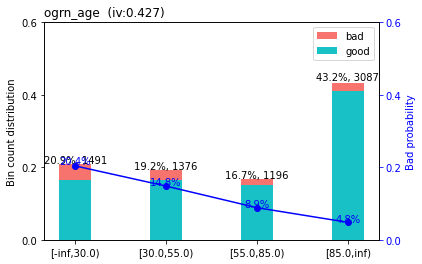

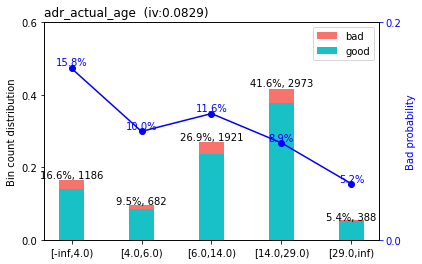

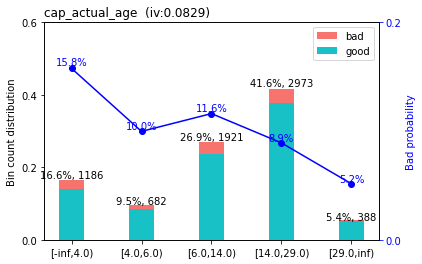

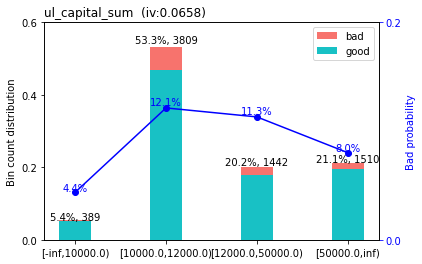

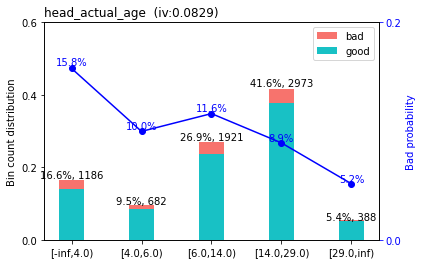

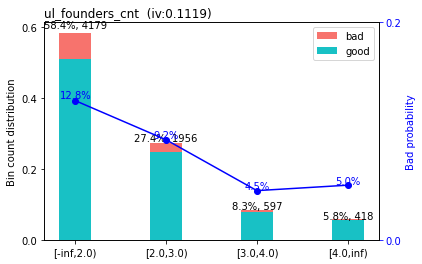

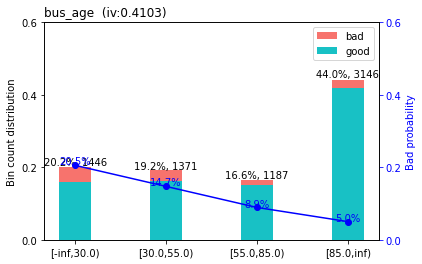

In [52]:
dt_s = sc.var_filter(X_train_1, y='default_12m')
bins_1 = sc.woebin(dt_s, y='default_12m')
sc.woebin_plot(bins_1)

In [53]:
X_train_woe_1 = sc.woebin_ply(X_train_1, bins_1)
X_test_woe_1 = sc.woebin_ply(X_test_1, bins_1)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [54]:
X_train_woe_1

,default_12m,ul_branch_cnt,ul_staff_range,ogrn_age_woe,adr_actual_age_woe,cap_actual_age_woe,ul_capital_sum_woe,head_actual_age_woe,ul_founders_cnt_woe,bus_age_woe
1,0.0,0,1,-0.856776,0.094727,0.094727,0.144507,0.094727,-0.814652,-0.815003
2,0.0,0,1,0.376415,-0.199474,-0.199474,0.144507,-0.199474,-0.164400,0.369126
5,0.0,0,1,-0.856776,-0.075725,-0.075725,-0.315787,-0.075725,0.206191,-0.815003
7,0.0,0,1,0.376415,-0.787589,-0.787589,0.144507,-0.787589,-0.164400,0.369126
8,0.0,0,1,0.762605,-0.199474,-0.199474,0.144507,-0.199474,0.206191,0.771847
...,...,...,...,...,...,...,...,...,...,...
32348,0.0,0,1,-0.856776,0.094727,0.094727,0.144507,0.094727,-0.164400,-0.815003
32364,0.0,0,1,0.376415,0.094727,0.094727,0.144507,0.094727,-0.164400,0.369126
32366,0.0,0,1,-0.856776,-0.199474,-0.199474,0.144507,-0.199474,0.206191,-0.815003
32383,0.0,0,1,-0.856776,-0.199474,-0.199474,-0.960919,-0.199474,-0.164400,-0.815003


Данные с финансовой отчетностью

In [55]:
X_2 = train_df_2.drop(['default_12m'], axis=1)
y_2 = train_df_2['default_12m']

In [56]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.3)

In [57]:
X_train_2['default_12m'] = y_train_2
X_test_2['default_12m'] = y_test_2
X_2['default_12m'] = y_2

[INFO] filtering variables ...
Variable filtering on 11462 rows and 70 columns in 00:05:21 
1 variables are removed
[INFO] creating woe binning ...
Binning on 11462 rows and 69 columns in 00:00:37


{'adr_actual_age': <Figure size 432x288 with 2 Axes>,
 'F16': <Figure size 432x288 with 2 Axes>,
 'quick_ratio': <Figure size 432x288 with 2 Axes>,
 'bus_age': <Figure size 432x288 with 2 Axes>,
 'ab_own_capital': <Figure size 432x288 with 2 Axes>,
 'return_on_production': <Figure size 432x288 with 2 Axes>,
 'F04': <Figure size 432x288 with 2 Axes>,
 'F05': <Figure size 432x288 with 2 Axes>,
 'ar_balance_of_rvns_and_expns': <Figure size 432x288 with 2 Axes>,
 'cash_ratio': <Figure size 432x288 with 2 Axes>,
 'reserves_coverage_ratio': <Figure size 432x288 with 2 Axes>,
 'F01': <Figure size 432x288 with 2 Axes>,
 'F10': <Figure size 432x288 with 2 Axes>,
 'ul_capital_sum': <Figure size 432x288 with 2 Axes>,
 'ab_borrowed_capital': <Figure size 432x288 with 2 Axes>,
 'F07': <Figure size 432x288 with 2 Axes>,
 'ul_staff_range': <Figure size 432x288 with 2 Axes>,
 'F20': <Figure size 432x288 with 2 Axes>,
 'F12': <Figure size 432x288 with 2 Axes>,
 'F15': <Figure size 432x288 with 2 Axes>,

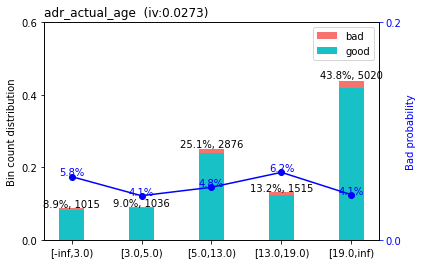

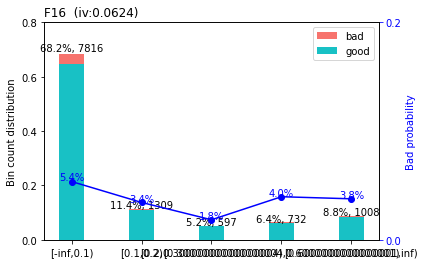

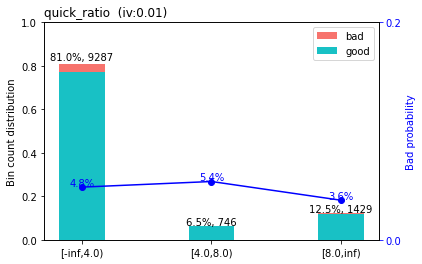

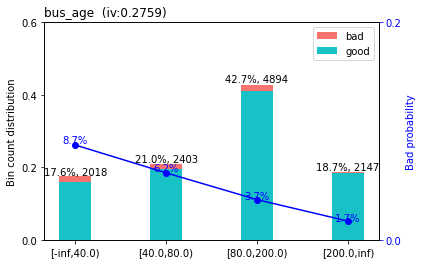

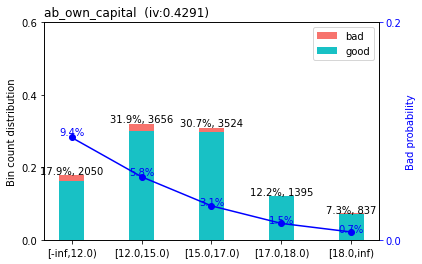

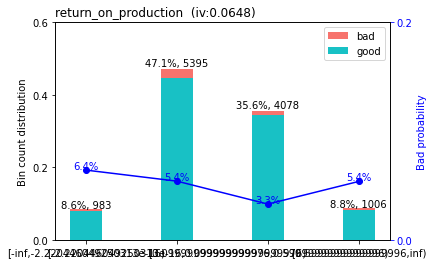

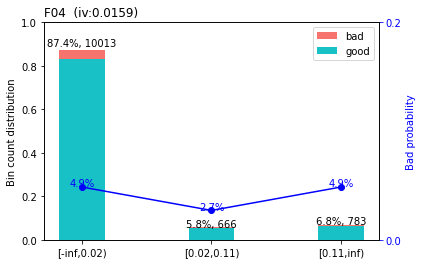

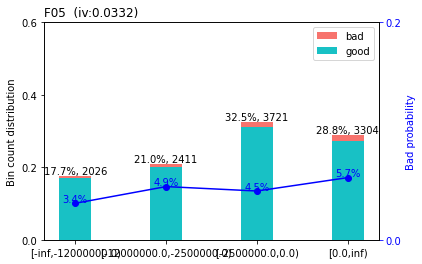

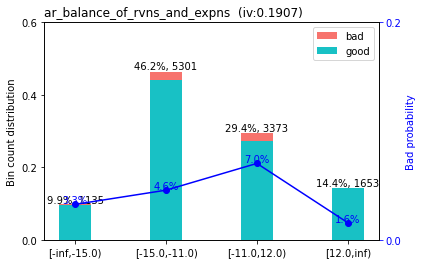

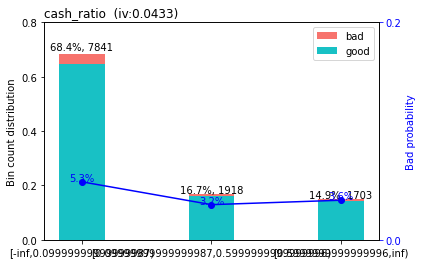

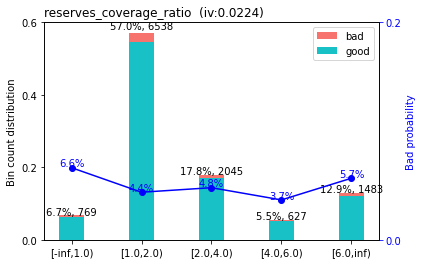

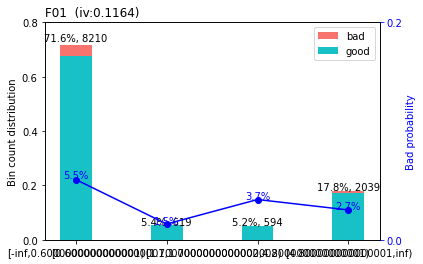

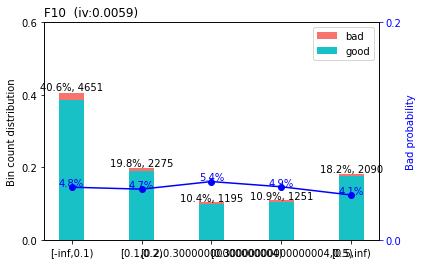

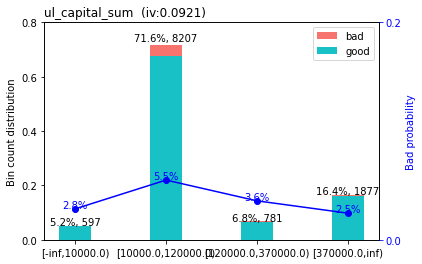

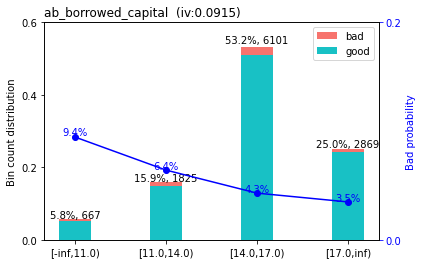

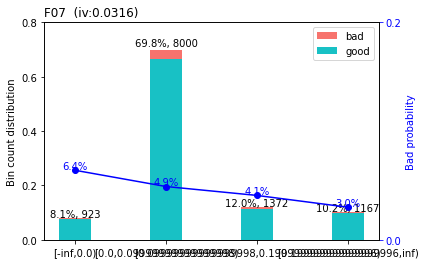

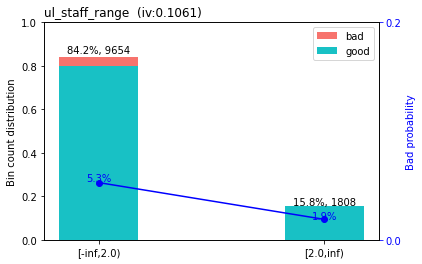

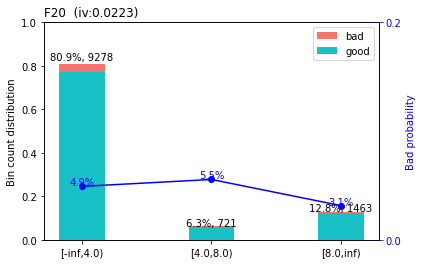

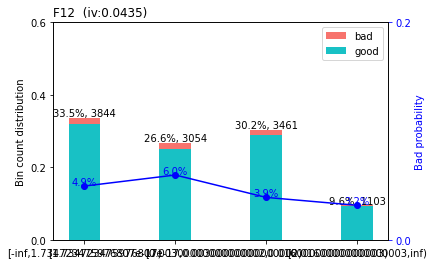

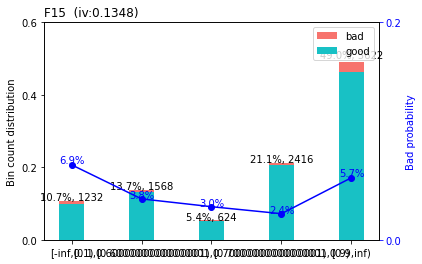

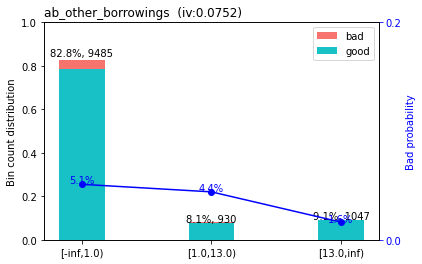

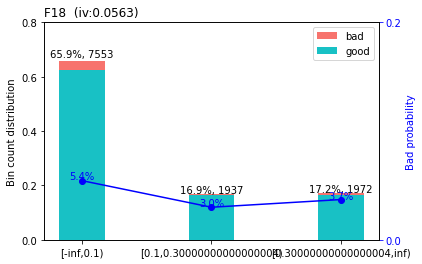

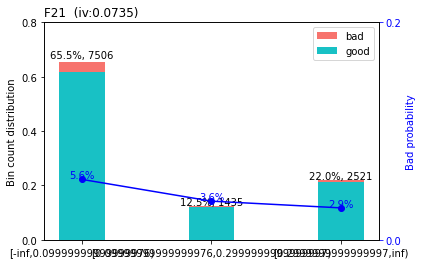

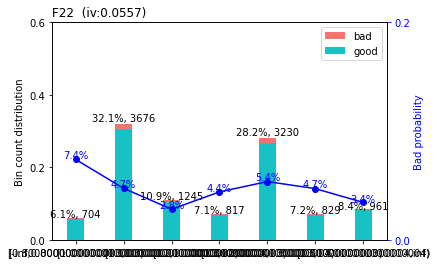

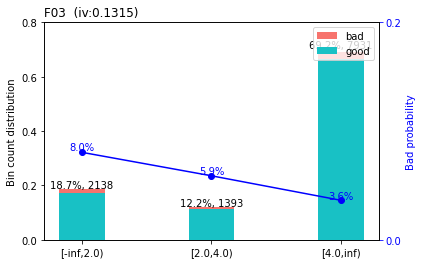

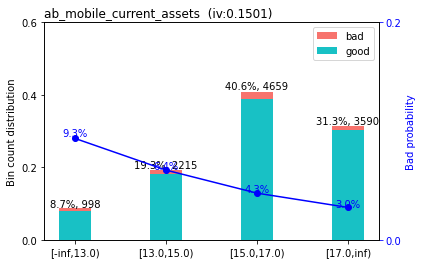

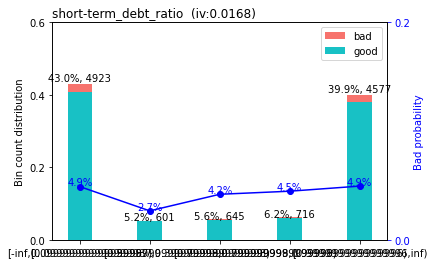

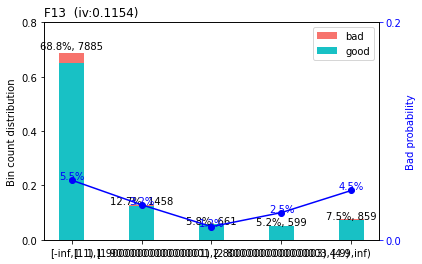

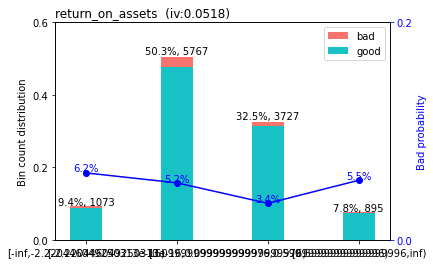

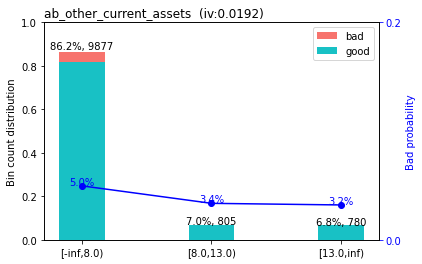

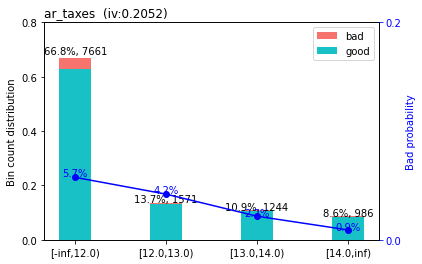

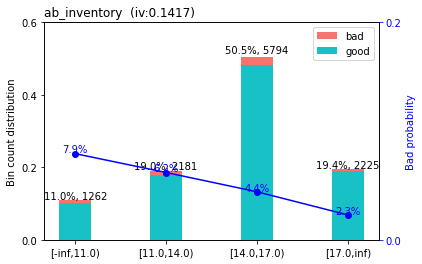

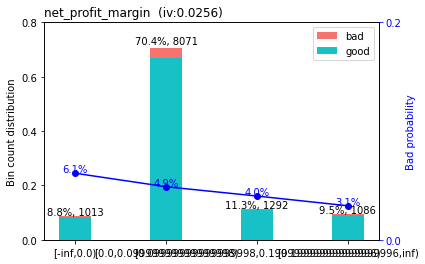

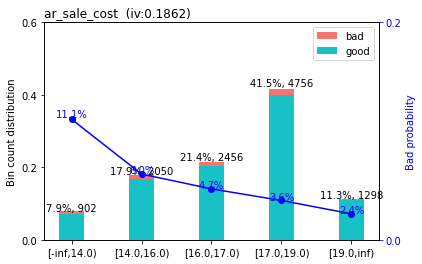

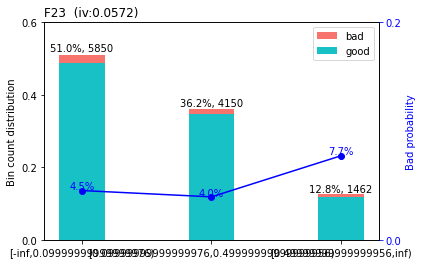

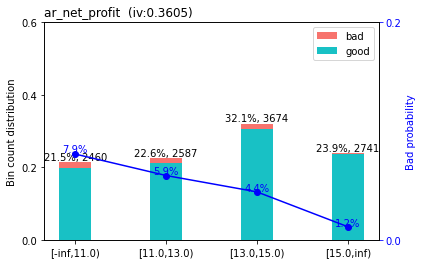

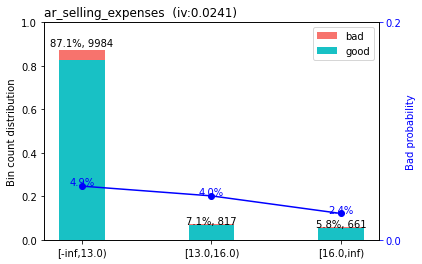

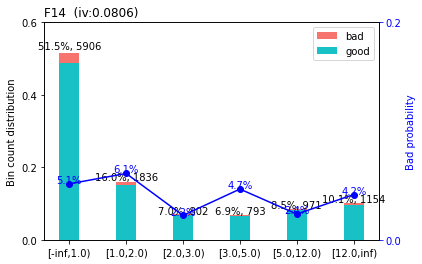

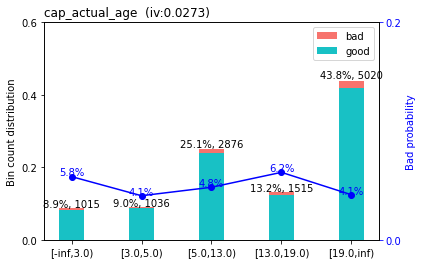

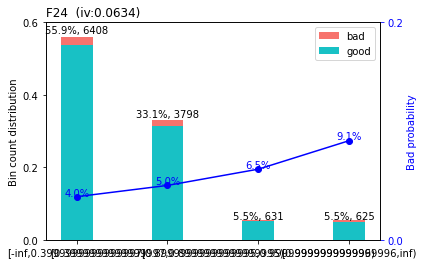

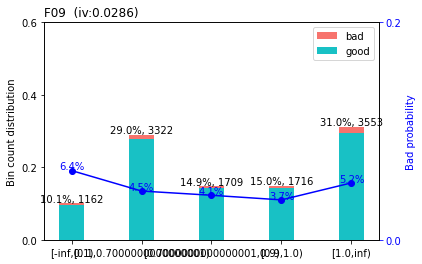

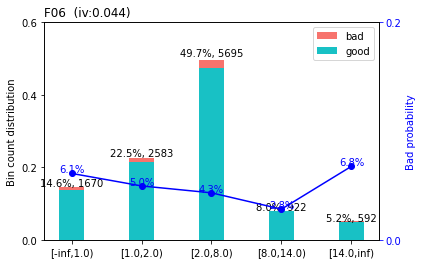

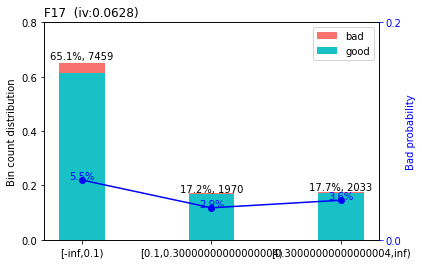

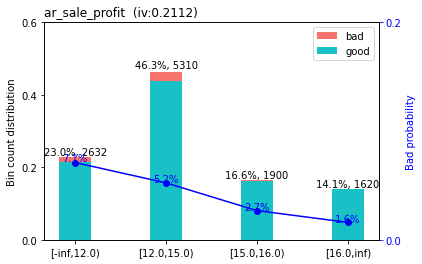

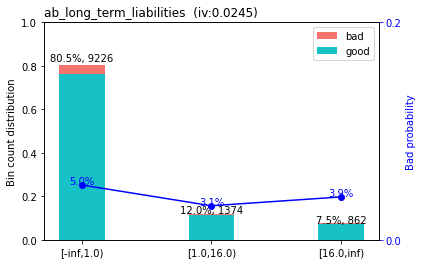

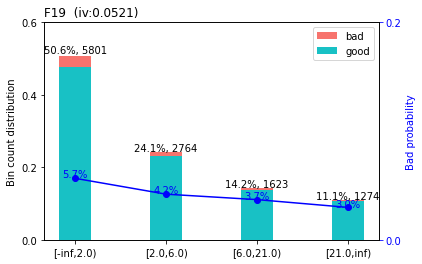

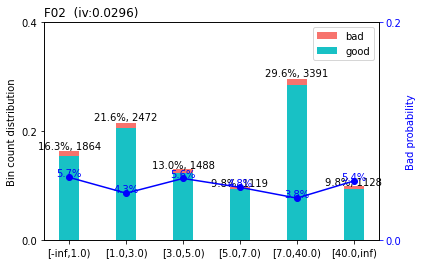

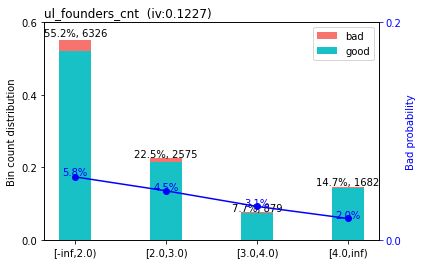

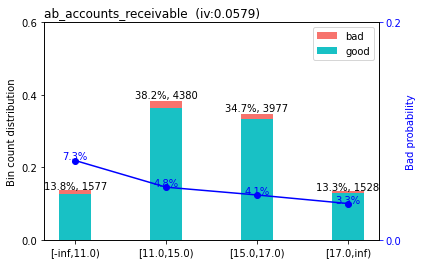

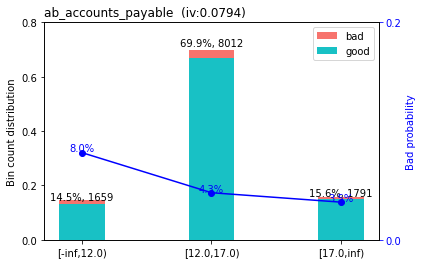

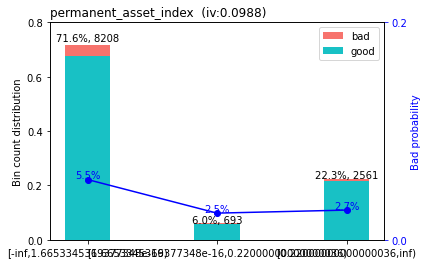

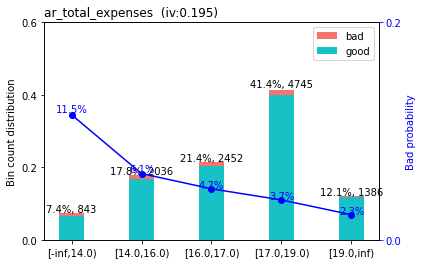

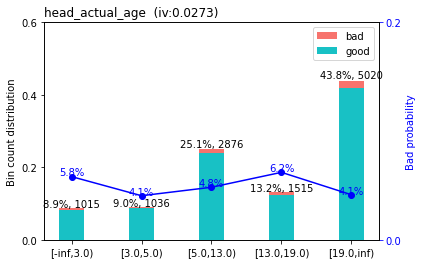

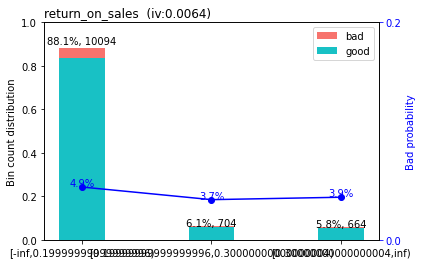

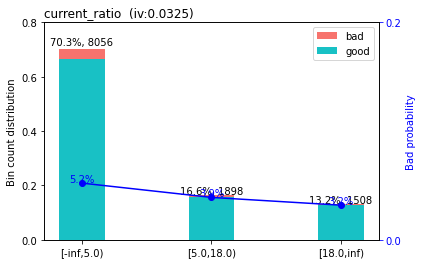

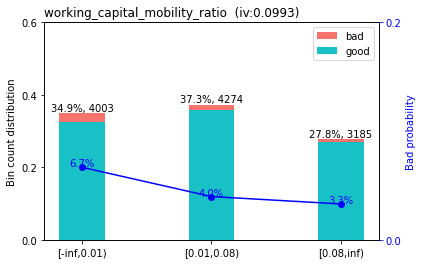

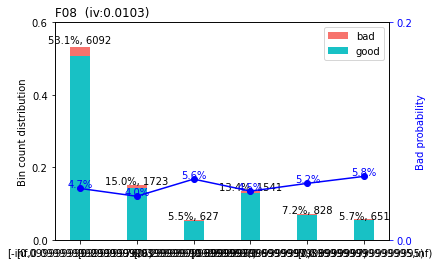

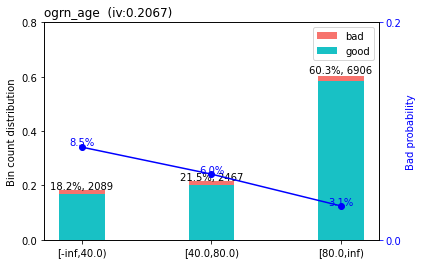

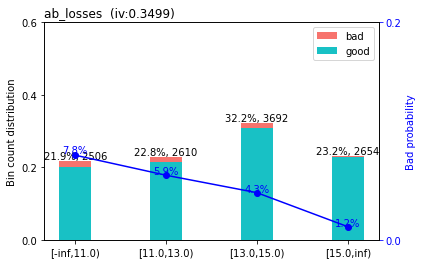

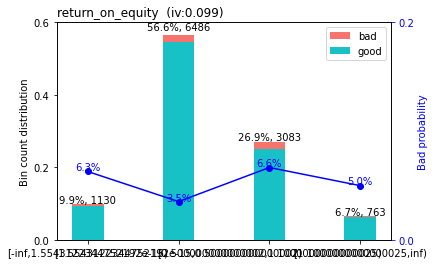

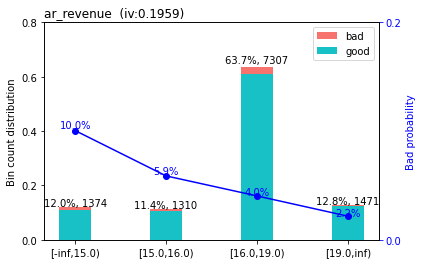

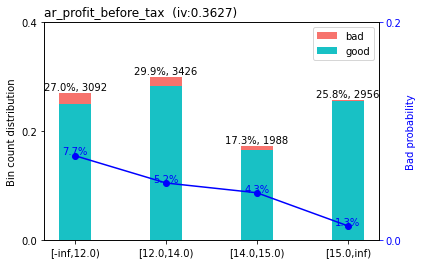

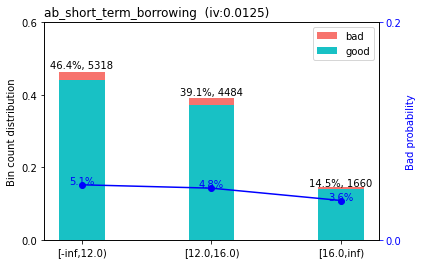

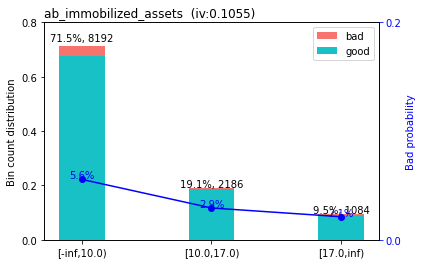

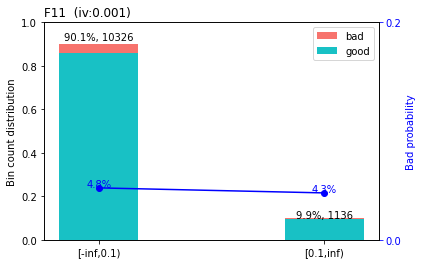

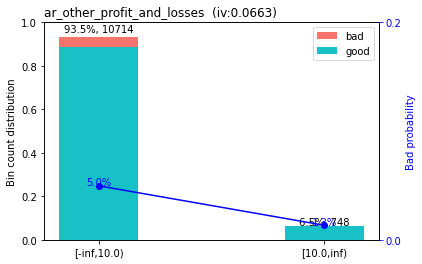

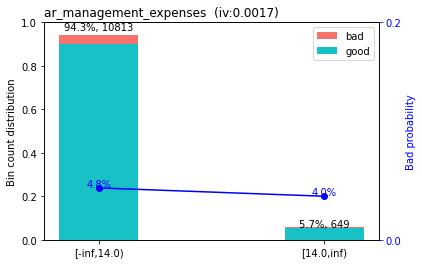

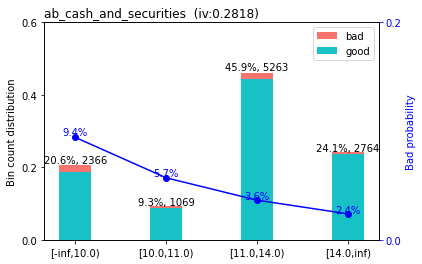

In [58]:
dt_s = sc.var_filter(X_train_2, y='default_12m')
bins_2 = sc.woebin(dt_s, y='default_12m')
sc.woebin_plot(bins_2)

In [59]:
X_train_woe_2 = sc.woebin_ply(X_train_2, bins_2)
X_test_woe_2 = sc.woebin_ply(X_test_2, bins_2)

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [60]:
X_train_woe_2

,default_12m,ul_branch_cnt,adr_actual_age_woe,cap_actual_age_woe,F14_woe,F16_woe,F24_woe,quick_ratio_woe,bus_age_woe,F06_woe,ab_own_capital_woe,return_on_production_woe,F09_woe,F04_woe,ar_sale_profit_woe,...,ab_losses_woe,ab_inventory_woe,net_profit_margin_woe,return_on_equity_woe,ar_sale_cost_woe,ar_profit_before_tax_woe,ab_short_term_borrowing_woe,F23_woe,ab_immobilized_assets_woe,ar_net_profit_woe,ar_selling_expenses_woe,ar_revenue_woe,ar_other_profit_and_losses_woe,ar_management_expenses_woe,ab_cash_and_securities_woe
0,0.0,0,-0.160982,-0.160982,0.269182,0.132126,-0.184438,0.025630,-0.256498,-0.094771,0.215283,-0.379026,-0.055401,0.027409,-0.587489,...,-0.091360,-0.071126,0.033452,0.054500,-0.279748,-0.093229,-0.280329,0.523354,0.169613,-0.073259,0.045495,-0.165318,0.051352,0.009584,-0.270713
3,0.0,0,0.022941,0.022941,0.089234,0.132126,-0.184438,0.025630,-0.256498,-0.094771,0.215283,-0.379026,0.315054,0.027409,0.107134,...,-0.091360,-0.071126,0.033452,0.361244,-0.279748,-0.093229,0.004774,0.523354,0.169613,-0.073259,0.045495,-0.165318,0.051352,0.009584,0.198236
4,0.0,0,-0.138245,-0.138245,-0.715775,-0.184976,-0.184438,0.025630,-1.040440,0.049233,-0.432074,-0.379026,0.107055,0.027409,0.107134,...,-0.091360,-0.071126,0.033452,-0.309185,-0.010316,-0.093229,0.070851,-0.045025,0.169613,-0.073259,0.045495,-0.165318,0.051352,0.009584,-0.270713
9,0.0,0,0.287264,0.287264,0.089234,0.132126,0.059200,-0.273334,-0.256498,-0.094771,-0.432074,-0.379026,-0.264127,0.027409,0.107134,...,-0.091360,-0.071126,0.033452,-0.309185,-0.279748,-0.093229,0.070851,-0.045025,0.169613,-0.073259,0.045495,-0.165318,0.051352,0.009584,-0.270713
12,0.0,0,0.022941,0.022941,0.089234,0.132126,-0.184438,0.025630,0.654962,0.270502,0.739058,0.138629,0.107055,0.027287,0.107134,...,0.240628,-0.749413,0.033452,0.361244,0.260166,0.523422,0.070851,-0.045025,-0.498146,0.236232,-0.693576,-0.165318,0.051352,-0.173365,-0.707526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32386,0.0,0,-0.138245,-0.138245,0.089234,0.132126,0.059200,0.025630,-0.256498,0.049233,-0.432074,0.138629,0.107055,0.027409,-0.587489,...,-1.402872,-0.749413,0.033452,0.361244,-0.707335,-1.337982,0.070851,-0.045025,-0.498146,-1.404373,0.045495,-0.802883,0.051352,0.009584,-0.707526
32388,0.0,0,0.217865,0.217865,0.089234,0.132126,-0.184438,0.025630,-0.256498,-0.094771,0.739058,0.138629,-0.150261,0.027409,-0.587489,...,0.530649,-0.071126,0.033452,0.300685,-0.279748,0.104984,0.004774,-0.187592,-0.498146,0.545172,0.045495,-0.165318,0.051352,0.009584,-0.270713
32391,0.0,0,-0.138245,-0.138245,-0.715775,0.132126,-0.184438,0.025630,-0.256498,-0.536759,0.215283,-0.379026,0.107055,0.027409,0.107134,...,-0.091360,-0.071126,0.033452,-0.309185,-0.279748,0.104984,0.070851,-0.045025,0.169613,-0.073259,0.045495,-0.165318,0.051352,0.009584,0.740295
32393,1.0,0,0.287264,0.287264,0.089234,0.132126,0.704015,0.132349,0.279392,-0.094771,0.215283,0.138629,0.315054,0.027409,0.107134,...,0.240628,0.550357,0.033452,-0.309185,-0.279748,0.104984,0.004774,0.523354,0.169613,0.236232,0.045495,-0.165318,0.051352,0.009584,0.198236


### Отбор признаков

In [61]:
y_train_woe_1 = X_train_woe_1['default_12m']
y_test_woe_1 = X_test_woe_1['default_12m']
X_train_woe_1.drop(['default_12m'], axis=1, inplace=True)
X_test_woe_1.drop(['default_12m'], axis=1, inplace=True)

In [62]:
#5 моделей
logreg1 = LogisticRegression(solver='liblinear')
logreg2 = LogisticRegression(solver='liblinear')
logreg3 = LogisticRegression(solver='liblinear')
logreg4 = LogisticRegression(solver='liblinear')
logreg5 = LogisticRegression(solver='liblinear')
logregs = [logreg1, logreg2, logreg3, logreg4, logreg5]
logregs

[LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear')]

In [63]:
class FeatureSelection:
    
    def __init__(self, models, metrics, metric_score, nfolds=5, shuffle=True, verbose=False, random_state=None):

        if len(models) != nfolds:
            raise ValueError("The number of models should be the same as nfolds")
        self.models = models
        self.metrics = metrics
        self.metric_score = metric_score
        self.nfolds = nfolds
        self.shuffle = shuffle
        self.verbose = verbose
        self.random_state = random_state
        self.kf = KFold(n_splits=nfolds, shuffle=shuffle, random_state=random_state)
    
    def PIMP(self, train, y): #Permutation IMPortance
        self.trains = []
        self.tests = []
        for training, testing in self.kf.split(train):
            self.trains.append(training)
            self.tests.append(testing)
        i=0
        self.metric_scores = []
        for training, testing in zip(self.trains, self.tests):
            self.models[i].fit(train.iloc[training, :], y[training])
            self.metric_scores.append(self.metric_score(y[testing], self.models[i].predict_proba(train.iloc[testing, :])[:, 1]))
            if self.verbose:
                print("fold = %d, score = %f" % (i, self.metric_scores[i]))
            i += 1
        self.base_score=np.mean(self.metric_scores)
        if self.verbose:
            print("base_score = %f" % self.base_score)
        
        self.scores = pd.DataFrame(np.array([[0.0] for i in range(len(train.columns))]).transpose(), columns=train.columns)
        iteration = 0
        for col in train.columns:
            iteration += 1
            col_buf = train[col].copy()  
            i=0
            train[col] = shuffle(train[col], random_state=self.random_state).values
            for training, testing in zip(self.trains, self.tests):
                self.scores[col] += self.metric_score(y[testing], self.models[i].predict_proba(train.iloc[testing,:])[:, 1])
                i += 1
            self.scores[col] = self.base_score - self.scores[col] / self.nfolds
            train[col] = col_buf.copy()
            if self.verbose:
                print("iteration = %d, feature = %s, score = %f" % (iteration, col, self.scores[col]))
                
        useful_features = []
        useless_features = []
        for col in train.columns:
            if float(self.scores[col]) > 0:
                useful_features.append([col, float(self.scores[col])])
            else:
                useless_features.append([col, float(self.scores[col])])
        
        self.len_useful_features = len(useful_features)
        self.len_useless_features = len(useless_features)
        if len(useful_features) > 0:
            self.sorted_useful_features = list(np.array(sorted(useful_features, key=lambda x: x[1], reverse=True))[:,0])
        else:
            self.sorted_useful_features = []
        if len(useless_features) > 0:
            self.sorted_useless_features = list(np.array(sorted(useless_features, key=lambda x: x[1]))[:,0])
        else:
            self.sorted_useless_features = []
        
        self.new_train = train.loc[:, list(np.array(useful_features)[:, 0])].copy()
        i=0
        self.metric_scores = []
        for training, testing in zip(self.trains, self.tests):
            self.models[0].fit(self.new_train.iloc[training, :], y[training])
            self.metric_scores.append(self.metric_score(y[testing], self.models[0].predict_proba(self.new_train.iloc[testing, :])[:, 1]))
            if self.verbose:
                print("fold = %d, score = %f" % (i, self.metric_scores[i]))
            i += 1
        self.new_score=np.mean(self.metric_scores)
        if self.verbose:
            print("roc_auc = %f" % self.new_score)
            print("before - %f, after - %f" % (self.base_score, self.new_score))
            
    def forward_selection(self, train, y, features, PIMPused=False, featuresAlreadySorted=False): #Forward selection
        if not PIMPused:
            if featuresAlreadySorted:
                self.sorted_useful_features = features
                self.new_train = train.loc[:, features].copy()
            else:
                self.sorted_useful_features = list(np.array(sorted(features, key=lambda x: x[1], reverse=True))[:,0])
                self.new_train = train.loc[:, list(np.array(features)[:, 0])].copy()
            self.trains = []
            self.tests = []
            for training, testing in self.kf.split(train):
                self.trains.append(training)
                self.tests.append(testing)
        self.improved_useful_features = []
        self.best_score = 0.0
        for feature in self.sorted_useful_features:
            current_score = 0.0
            for training, testing in zip(self.trains, self.tests):
                self.models[0].fit(self.new_train[self.improved_useful_features + [feature]].iloc[training, :], y[training])
                current_score += self.metric_score(y[testing], self.models[0].predict_proba(self.new_train[self.improved_useful_features+[feature]].iloc[testing, :])[:, 1])
            current_score /= self.nfolds
            if self.verbose:
                print("feature = %s, current_score = %f, best_score = %f" % (feature, current_score, self.best_score))
            if current_score > self.best_score:
                self.improved_useful_features.append(feature)
                self.best_score = current_score
                
    def backward_selection(self, train, y, features, PIMPused=False, featuresAlreadySorted=False): #Backward selection
        if not PIMPused:
            self.sorted_useless_features = features
            self.trains = []
            self.tests = []
            for training, testing in self.kf.split(train):
                self.trains.append(training)
                self.tests.append(testing)
        self.improved_useful_features = list(train.columns)
        self.best_score = 0.0
        for feature in self.sorted_useless_features:
            current_score = 0.0
            for training, testing in zip(self.trains, self.tests):
                self.models[0].fit(train.drop(feature, axis=1).iloc[training, :], y[training])
                current_score += self.metric_score(y[testing], self.models[0].predict_proba(train.drop(feature,axis=1).iloc[testing, :])[:, 1])
            current_score /= self.nfolds
            if self.verbose:
                print("feature = %s, current_score = %f, best_score = %f" % (feature, current_score, self.best_score))
            if current_score > self.best_score:
                self.improved_useful_features.remove(feature)
                self.best_score = current_score

In [64]:
select = FeatureSelection(models=logregs, metrics='roc_auc', metric_score=roc_auc_score, verbose=True, random_state=0)

In [65]:
X_train_woe_1.reset_index(drop=True, inplace=True)
y_train_woe_1.reset_index(drop=True, inplace=True)

In [66]:
select.PIMP(X_train_woe_1, y_train_woe_1)

fold = 0, score = 0.709401
fold = 1, score = 0.744136
fold = 2, score = 0.711686
fold = 3, score = 0.700036
fold = 4, score = 0.681126
base_score = 0.709277
iteration = 1, feature = ul_branch_cnt, score = -0.000962
iteration = 2, feature = ul_staff_range, score = -0.000163
iteration = 3, feature = ogrn_age_woe, score = 0.102719
iteration = 4, feature = adr_actual_age_woe, score = 0.001314
iteration = 5, feature = cap_actual_age_woe, score = 0.001314
iteration = 6, feature = ul_capital_sum_woe, score = 0.008889
iteration = 7, feature = head_actual_age_woe, score = 0.001316
iteration = 8, feature = ul_founders_cnt_woe, score = 0.028381
iteration = 9, feature = bus_age_woe, score = 0.002197
fold = 0, score = 0.711167
fold = 1, score = 0.742703
fold = 2, score = 0.715845
fold = 3, score = 0.699241
fold = 4, score = 0.680450
roc_auc = 0.709881
before - 0.709277, after - 0.709881


In [67]:
select.forward_selection(X_train_woe_1, y_train_woe_1, select.sorted_useful_features, True)

feature = ogrn_age_woe, current_score = 0.674740, best_score = 0.000000
feature = ul_founders_cnt_woe, current_score = 0.697544, best_score = 0.674740
feature = ul_capital_sum_woe, current_score = 0.701638, best_score = 0.697544
feature = bus_age_woe, current_score = 0.701332, best_score = 0.701638
feature = head_actual_age_woe, current_score = 0.710013, best_score = 0.701638
feature = adr_actual_age_woe, current_score = 0.710034, best_score = 0.710013
feature = cap_actual_age_woe, current_score = 0.710135, best_score = 0.710034


In [68]:
top_features_1 = select.improved_useful_features
top_features_1

['ogrn_age_woe',
 'ul_founders_cnt_woe',
 'ul_capital_sum_woe',
 'head_actual_age_woe',
 'adr_actual_age_woe',
 'cap_actual_age_woe']

In [69]:
X_train_woe_1[top_features_1].corr()

,ogrn_age_woe,ul_founders_cnt_woe,ul_capital_sum_woe,head_actual_age_woe,adr_actual_age_woe,cap_actual_age_woe
ogrn_age_woe,1.000000,0.031603,0.246237,0.129435,0.129435,0.129435
ul_founders_cnt_woe,0.031603,1.000000,0.070988,-0.032279,-0.032279,-0.032279
ul_capital_sum_woe,0.246237,0.070988,1.000000,-0.059281,-0.059281,-0.059281
head_actual_age_woe,0.129435,-0.032279,-0.059281,1.000000,1.000000,1.000000
adr_actual_age_woe,0.129435,-0.032279,-0.059281,1.000000,1.000000,1.000000
cap_actual_age_woe,0.129435,-0.032279,-0.059281,1.000000,1.000000,1.000000


In [70]:
#head_actual_age_woe коррелирует с cap_actual_age_woe, удалим его
#cap_actual_age_woe коррелирует с adr_actual_age_woe, удалим его
top_features_1.remove('head_actual_age_woe')
top_features_1.remove('cap_actual_age_woe')
top_features_1

['ogrn_age_woe',
 'ul_founders_cnt_woe',
 'ul_capital_sum_woe',
 'adr_actual_age_woe']

In [71]:
gini_features = pd.DataFrame(index=top_features_1, columns=['Gini'])
for feat in top_features_1:
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train_woe_1.loc[:, feat].values.reshape(-1,1), y_train_woe_1)
    preds_train = logreg.predict_proba(X_train_woe_1.loc[:, feat].values.reshape(-1,1))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_1, preds_train) - 1
gini_features

,Gini
ogrn_age_woe,0.350449
ul_founders_cnt_woe,0.149127
ul_capital_sum_woe,0.108546
adr_actual_age_woe,0.150442


In [72]:
X_train_woe_1_final = X_train_woe_1[top_features_1]
X_test_woe_1_final = X_test_woe_1[top_features_1]

In [73]:
y_train_woe_2 = X_train_woe_2['default_12m']
y_test_woe_2 = X_test_woe_2['default_12m']
X_train_woe_2.drop(['default_12m'], axis=1, inplace=True)
X_test_woe_2.drop(['default_12m'], axis=1, inplace=True)

In [74]:
#5 моделей
logreg1 = LogisticRegression(solver='liblinear')
logreg2 = LogisticRegression(solver='liblinear')
logreg3 = LogisticRegression(solver='liblinear')
logreg4 = LogisticRegression(solver='liblinear')
logreg5 = LogisticRegression(solver='liblinear')
logregs = [logreg1, logreg2, logreg3, logreg4, logreg5]
logregs

[LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear'),
 LogisticRegression(solver='liblinear')]

In [75]:
select = FeatureSelection(models=logregs, metrics='roc_auc', metric_score=roc_auc_score, verbose=True, random_state=0)

In [76]:
X_train_woe_2.reset_index(drop=True, inplace=True)
y_train_woe_2.reset_index(drop=True, inplace=True)

In [77]:
select.PIMP(X_train_woe_2, y_train_woe_2)

fold = 0, score = 0.750191
fold = 1, score = 0.709124
fold = 2, score = 0.737594
fold = 3, score = 0.743798
fold = 4, score = 0.721592
base_score = 0.732460
iteration = 1, feature = ul_branch_cnt, score = -0.000478
iteration = 2, feature = adr_actual_age_woe, score = 0.000688
iteration = 3, feature = cap_actual_age_woe, score = 0.000688
iteration = 4, feature = F14_woe, score = 0.005972
iteration = 5, feature = F16_woe, score = 0.001921
iteration = 6, feature = F24_woe, score = 0.001895
iteration = 7, feature = quick_ratio_woe, score = -0.000139
iteration = 8, feature = bus_age_woe, score = 0.018772
iteration = 9, feature = F06_woe, score = 0.001175
iteration = 10, feature = ab_own_capital_woe, score = 0.001602
iteration = 11, feature = return_on_production_woe, score = -0.000545
iteration = 12, feature = F09_woe, score = 0.004339
iteration = 13, feature = F04_woe, score = -0.001331
iteration = 14, feature = ar_sale_profit_woe, score = 0.004840
iteration = 15, feature = ab_long_term_li

In [78]:
select.forward_selection(X_train_woe_2, y_train_woe_2, select.sorted_useful_features, True)

feature = bus_age_woe, current_score = 0.639343, best_score = 0.000000
feature = ab_cash_and_securities_woe, current_score = 0.691718, best_score = 0.639343
feature = ar_taxes_woe, current_score = 0.701981, best_score = 0.691718
feature = ar_net_profit_woe, current_score = 0.711873, best_score = 0.701981
feature = F14_woe, current_score = 0.718793, best_score = 0.711873
feature = ab_inventory_woe, current_score = 0.719786, best_score = 0.718793
feature = ar_sale_profit_woe, current_score = 0.721373, best_score = 0.719786
feature = F15_woe, current_score = 0.724929, best_score = 0.721373
feature = ar_sale_cost_woe, current_score = 0.724538, best_score = 0.724929
feature = F22_woe, current_score = 0.725480, best_score = 0.724929
feature = F09_woe, current_score = 0.725508, best_score = 0.725480
feature = ar_profit_before_tax_woe, current_score = 0.725172, best_score = 0.725508
feature = F01_woe, current_score = 0.727274, best_score = 0.725508
feature = F20_woe, current_score = 0.728471, 

In [79]:
top_features_2 = select.improved_useful_features
top_features_2

['bus_age_woe',
 'ab_cash_and_securities_woe',
 'ar_taxes_woe',
 'ar_net_profit_woe',
 'F14_woe',
 'ab_inventory_woe',
 'ar_sale_profit_woe',
 'F15_woe',
 'F22_woe',
 'F09_woe',
 'F01_woe',
 'F20_woe',
 'ab_accounts_receivable_woe',
 'F23_woe',
 'ab_other_borrowings_woe',
 'ar_balance_of_rvns_and_expns_woe',
 'F24_woe',
 'ab_own_capital_woe',
 'F13_woe',
 'ar_management_expenses_woe',
 'F06_woe',
 'adr_actual_age_woe',
 'F11_woe']

In [80]:
X_train_woe_2[top_features_2].corr()

,bus_age_woe,ab_cash_and_securities_woe,ar_taxes_woe,ar_net_profit_woe,F14_woe,ab_inventory_woe,ar_sale_profit_woe,F15_woe,F22_woe,F09_woe,F01_woe,F20_woe,ab_accounts_receivable_woe,F23_woe,ab_other_borrowings_woe,ar_balance_of_rvns_and_expns_woe,F24_woe,ab_own_capital_woe,F13_woe,ar_management_expenses_woe,F06_woe,adr_actual_age_woe,F11_woe
bus_age_woe,1.000000,0.158997,0.168993,0.258131,0.157967,0.340446,0.246216,0.056029,0.136479,0.043144,0.203406,-0.035926,0.112949,0.133525,0.173335,0.303936,0.278996,0.496778,0.213346,0.054951,0.008260,-0.032877,0.118776
ab_cash_and_securities_woe,0.158997,1.000000,0.299395,0.336184,-0.032093,0.330721,0.353071,0.416502,0.064564,0.192354,0.170333,0.096605,0.415770,0.074839,0.139433,0.271595,-0.023293,0.368919,-0.053787,0.123353,0.088698,0.013349,0.074826
ar_taxes_woe,0.168993,0.299395,1.000000,0.470411,-0.069047,0.309074,0.544856,0.072666,-0.000472,0.189473,0.090881,0.124441,0.406913,0.095712,0.136278,0.224675,0.010695,0.396703,-0.050045,0.135300,0.135701,-0.003501,-0.056857
ar_net_profit_woe,0.258131,0.336184,0.470411,1.000000,0.132024,0.461713,0.768795,0.090421,0.193063,0.111735,0.265510,0.033973,0.336309,0.176261,0.214743,0.393876,0.155870,0.675987,0.148436,0.074779,0.033738,-0.025363,0.150549
F14_woe,0.157967,-0.032093,-0.069047,0.132024,1.000000,0.171608,0.079867,0.021791,0.103757,-0.055818,0.084370,-0.086179,-0.096687,-0.060553,0.064650,0.107441,0.196408,0.215486,0.414048,-0.035739,-0.043684,-0.000128,0.117275
ab_inventory_woe,0.340446,0.330721,0.309074,0.461713,0.171608,1.000000,0.475763,0.079270,0.138756,0.260588,0.302150,0.004732,0.423071,0.161468,0.213947,0.451359,0.378123,0.636635,0.209887,0.128201,-0.013377,-0.013776,0.186424
ar_sale_profit_woe,0.246216,0.353071,0.544856,0.768795,0.079867,0.475763,1.000000,0.073753,0.171484,0.135331,0.225957,0.047019,0.404512,0.137238,0.155301,0.268013,0.125104,0.629159,0.087218,0.112839,0.060364,-0.006376,0.084994
F15_woe,0.056029,0.416502,0.072666,0.090421,0.021791,0.079270,0.073753,1.000000,0.017318,0.076061,0.072990,0.006257,0.173350,0.035508,0.037532,0.074754,0.039227,0.110908,0.027254,0.021333,0.076874,0.014540,0.038973
F22_woe,0.136479,0.064564,-0.000472,0.193063,0.103757,0.138756,0.171484,0.017318,1.000000,0.019216,-0.000732,-0.023083,0.070124,0.044195,0.018003,0.141559,0.108211,0.197776,0.117488,-0.036216,0.015479,0.002754,0.021264
F09_woe,0.043144,0.192354,0.189473,0.111735,-0.055818,0.260588,0.135331,0.076061,0.019216,1.000000,0.089352,0.404607,0.374508,0.213197,0.131108,0.197313,0.030405,0.147036,-0.063471,0.089674,0.115988,0.020313,0.015836


In [81]:
#ab_own_capital_woe коррелирует с ar_net_profit_woe, удалим его
#ar_sale_profit_woe коррелирует с ar_net_profit_woe, удалим его
top_features_2.remove('ab_own_capital_woe')
top_features_2.remove('ar_sale_profit_woe')
top_features_2

['bus_age_woe',
 'ab_cash_and_securities_woe',
 'ar_taxes_woe',
 'ar_net_profit_woe',
 'F14_woe',
 'ab_inventory_woe',
 'F15_woe',
 'F22_woe',
 'F09_woe',
 'F01_woe',
 'F20_woe',
 'ab_accounts_receivable_woe',
 'F23_woe',
 'ab_other_borrowings_woe',
 'ar_balance_of_rvns_and_expns_woe',
 'F24_woe',
 'F13_woe',
 'ar_management_expenses_woe',
 'F06_woe',
 'adr_actual_age_woe',
 'F11_woe']

In [82]:
gini_features = pd.DataFrame(index=top_features_2, columns=['Gini'])
for feat in top_features_2:
    logreg = LogisticRegression(solver='liblinear')
    logreg.fit(X_train_woe_2.loc[:, feat].values.reshape(-1,1), y_train_woe_2)
    preds_train = logreg.predict_proba(X_train_woe_2.loc[:, feat].values.reshape(-1,1))[:, 1]
    gini_features.loc[feat, 'Gini'] = 2*roc_auc_score(y_train_woe_2, preds_train) - 1
gini_features

,Gini
bus_age_woe,0.278662
ab_cash_and_securities_woe,0.282299
ar_taxes_woe,0.168462
ar_net_profit_woe,0.285562
F14_woe,0.127029
ab_inventory_woe,0.194183
F15_woe,0.184069
F22_woe,0.118348
F09_woe,0.093321
F01_woe,0.135431


In [83]:
top_features_2.remove('F11_woe')
top_features_2.remove('ar_management_expenses_woe')
top_features_2

['bus_age_woe',
 'ab_cash_and_securities_woe',
 'ar_taxes_woe',
 'ar_net_profit_woe',
 'F14_woe',
 'ab_inventory_woe',
 'F15_woe',
 'F22_woe',
 'F09_woe',
 'F01_woe',
 'F20_woe',
 'ab_accounts_receivable_woe',
 'F23_woe',
 'ab_other_borrowings_woe',
 'ar_balance_of_rvns_and_expns_woe',
 'F24_woe',
 'F13_woe',
 'F06_woe',
 'adr_actual_age_woe']

In [84]:
X_train_woe_2_final = X_train_woe_2[top_features_2]
X_test_woe_2_final = X_test_woe_2[top_features_2]

### Качество моделей

In [85]:
logreg_1 = LogisticRegression(solver='liblinear')
logreg_1.fit(X_train_woe_1_final, y_train_woe_1)
y_pred = logreg_1.predict_proba(X_test_woe_1_final)[:, 1]
print('logreg_1, ROC AUC:', roc_auc_score(y_test_woe_1, y_pred))

logreg_2 = LogisticRegression(solver='liblinear')
logreg_2.fit(X_train_woe_2_final, y_train_woe_2)
y_pred = logreg_2.predict_proba(X_test_woe_2_final)[:, 1]
print('logreg_2, ROC AUC:', roc_auc_score(y_test_woe_2, y_pred))

logreg_1, ROC AUC: 0.6701095557373414
logreg_2, ROC AUC: 0.6940567328470726


### Оптимизация гиперпараметров

In [86]:
logreg1 = LogisticRegression(solver='liblinear')
param_grid = {'C': np.arange(0.1, 5, 0.05)}
CV_logreg_1 = GridSearchCV(estimator=logreg1, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=3)
CV_logreg_1.fit(X_train_woe_1_final, y_train_woe_1)
CV_logreg_1.best_params_

{'C': 1.0500000000000003}

In [87]:
logreg2 = LogisticRegression(solver='liblinear')
param_grid = {'C': np.arange(0.1, 5, 0.05)}
CV_logreg_2 = GridSearchCV(estimator=logreg2, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=3)
CV_logreg_2.fit(X_train_woe_2_final, y_train_woe_2)
CV_logreg_2.best_params_

{'C': 0.30000000000000004}

In [89]:
logreg_1 = LogisticRegression(C=1.0500000000000003, solver='liblinear')
logreg_1.fit(X_train_woe_1_final, y_train_woe_1)
y_pred = logreg_1.predict_proba(X_test_woe_1_final)[:, 1]
print('logreg_1, ROC AUC:', roc_auc_score(y_test_woe_1, y_pred))

logreg_2 = LogisticRegression(C=0.30000000000000004, solver='liblinear')
logreg_2.fit(X_train_woe_2_final, y_train_woe_2)
y_pred = logreg_2.predict_proba(X_test_woe_2_final)[:, 1]
print('logreg_2, ROC AUC:', roc_auc_score(y_test_woe_2, y_pred))

logreg_1, ROC AUC: 0.6701108299375897
logreg_2, ROC AUC: 0.694200126771189


### Поиск оптимального cutoff

In [90]:
y_pred_0 = logreg_1.predict_proba(X_train_woe_1_final[y_train_woe_1==0].sample(500))[:, 1]
y_true_0 = [0.0] * 500

y_pred_1 = logreg_1.predict_proba(X_train_woe_1_final[y_train_woe_1==1].sample(500))[:, 1]
y_true_1 = [1.0] * 500

y_true = y_true_0 + y_true_1

best_score_1 = 0.0
best_cutoff_1 = 0.01
for cutoff in np.arange(0.05, 0.25, 0.001):
    y_pred = (y_pred_0 > cutoff).tolist() + (y_pred_1 > cutoff).tolist()
    score = accuracy_score(y_true, y_pred)
    if score > best_score_1:
        best_score_1 = score
        best_cutoff_1 = cutoff
best_cutoff_1

0.10200000000000005

In [105]:
best_score_1

0.665

In [91]:
y_pred_0 = logreg_2.predict_proba(X_train_woe_2_final[y_train_woe_2==0].sample(500))[:, 1]
y_true_0 = [0.0] * 500

y_pred_1 = logreg_2.predict_proba(X_train_woe_2_final[y_train_woe_2==1].sample(500))[:, 1]
y_true_1 = [1.0] * 500

y_true = y_true_0 + y_true_1

best_score_2 = 0.0
best_cutoff_2 = 0.01
for cutoff in np.arange(0.05, 0.25, 0.001):
    y_pred = (y_pred_0 > cutoff).tolist() + (y_pred_1 > cutoff).tolist()
    score = accuracy_score(y_true, y_pred)
    if score > best_score_2:
        best_score_2 = score
        best_cutoff_2 = cutoff
best_cutoff_2

0.05900000000000001

In [104]:
best_score_2

0.716

### Применение модели к тестовым данным

In [92]:
test_df_1 = test_data[test_data['ar_revenue'].isnull()]
test_df_2 = test_data[~test_data['ar_revenue'].isnull()]

In [93]:
record_id_1 = test_df_1['record_id']
record_id_2 = test_df_2['record_id']

Binning

In [95]:
test_df_2 = test_df_2.fillna(0)
test_df_2 = test_df_2.replace([np.inf, -np.inf], 0)

In [96]:
test_df_1 = sc.woebin_ply(test_df_1[X_train_1.columns], bins_1)[top_features_1]
test_df_2 = sc.woebin_ply(test_df_2[X_train_2.columns], bins_2)[top_features_2]

[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [97]:
X_1['default_12m'] = y_1
X_woe_1 = sc.woebin_ply(X_1, bins_1)

[INFO] converting into woe values ...


In [98]:
logreg_1 = LogisticRegression(C=1.0500000000000003, solver='liblinear')
logreg_1.fit(X_woe_1[top_features_1], X_woe_1['default_12m'])
y_pred_1 = logreg_1.predict_proba(test_df_1)[:, 1]
predict_1 = (y_pred_1 > best_cutoff_1).astype(int)

In [99]:
X_2['default_12m'] = y_2
X_woe_2 = sc.woebin_ply(X_2, bins_2)

[INFO] converting into woe values ...


In [100]:
logreg_2 = LogisticRegression(C=0.30000000000000004, solver='liblinear')
logreg_2.fit(X_woe_2[top_features_2], X_woe_2['default_12m'])
y_pred_2 = logreg_2.predict_proba(test_df_2)[:, 1]
predict_2 = (y_pred_2 > best_cutoff_2).astype(int)

In [101]:
ans_1 = dict(zip(record_id_1, predict_1))
ans_2 = dict(zip(record_id_2, predict_2))
ans_dict = ans_1.copy()
ans_dict.update(ans_2)

In [102]:
answ_df = test_df[['record_id']]
answ_df['id'] = answ_df['record_id']
answ_df['predict'] = answ_df['record_id']
answ_df['predict'] = answ_df['predict'].map(ans_dict)
answ_df.drop('record_id', axis=1, inplace=True)

In [103]:
answ_df.to_csv('PD-submit.csv', index=False, sep=';')